# Classification with PyTorch and BERT

### Dataset

The dataset is the same as in the word-embedding-raw file. But still not yet journal data!!

## PyTorch

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch import nn
torch.__version__

'1.10.1+cu102'

In [2]:
import csv
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
import pandas as pd
import numpy as np
#nltk.download('omw-1.4')


import sklearn

In [3]:
size = "small"

with open(f'nlpwdl2021_data/thedeep.{size}.train.txt', "r", encoding="utf8") as csvfile:
    train = list(csv.reader(csvfile)) # list of lists with 3 entries: sentence ID, text, label
    
with open(f'nlpwdl2021_data/thedeep.{size}.test.txt', "r", encoding="utf8") as csvfile:
    test = list(csv.reader(csvfile))
    
with open(f'nlpwdl2021_data/thedeep.{size}.validation.txt', "r", encoding="utf8") as csvfile:
    validation = list(csv.reader(csvfile))
    
print(len(train), len(test), len(validation))

8400 1800 1800



### Preprocessing and Dictionary 


In [4]:
def preprocess_text(text:str=None, return_label:bool=False, label:int=None):
    """function to preprocess string
    returns a list of tokens
    """
    #1 to lowercase
    text = text.lower()
    
    #2 remove all special characters
    text = re.sub(r"\W", " ", text)
    
    #3 remove single characters with space to the left and right (possessive pronoun)
    text = re.sub(r"\s+[a-z]\s+", " ", text)
    
    #4 remove double whitespaces to single space
    text = re.sub(' +', ' ', text)
    
    #5.2 replace numbers
    text = re.sub(r'\d+', '<num>', text)
    
    #5.3 now count frequncy of <dates> and <num>
    count_num, count_dates = text.count("<num>"), text.count("<dates>")
    
    #5.4 replace it (so that in tokens it does not appear)
    text = text.replace("<num>", "").replace("<dates>", "")
    
    #6 Stop words and tokenization
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    token_text = [i for i in tokens if not i in stop_words]
    
    #7 Lemmatization
    stemmer = WordNetLemmatizer()
    result = [stemmer.lemmatize(word) for word in token_text]
    if not return_label:
        return result
    else:
        return result, label

def create_dictionary(preprocessed_tokens:list=None):
    """Creates a word dictionary given a PREPROCESSED text. Returns a sorted dct of all counts and OOV as well as the count list"""
    threshold = 2

    count_list = list()
    filtered_dict = dict()
    out_of_vocabulary = list()
    
    word_dict = defaultdict(lambda: 0)
    for word in preprocessed_tokens:
        word_dict[word] += 1
    
    sorted_dict = {k: v for k, v in sorted(word_dict.items(), key=lambda item:item[1], reverse=True)}
    
    for key, value in sorted_dict.items():
        if value > threshold:
            filtered_dict[key] = value
        else:
            out_of_vocabulary.append(key)

        count_list.append(value)
    
    return sorted_dict, out_of_vocabulary, count_list, list(filtered_dict.values())

def merge_tokens(data:list):
    """
    function that preprocesses text and returns two different lists
    1. token_list ... used for dictionary to find out threshold value
    2. documents ... used for removing oov words
    """
    i = 0
    token_list = list() # list with all tokens of all douments ["word1", "word2", ...]
    documents = list() # elements are list of tokens [[doc1 tokens], [doc2 tokens], ...]
    
    for sample in tqdm(data):
        token_list += preprocess_text(sample[1])
        documents.append(preprocess_text(sample[1]))
        i += 1

        
    return token_list, documents


### Create the Dictionarys

In [5]:
text_and_labels_train = {} # contains all dictionarys of documtnts
text_and_labels_test = {} 
text_and_labels_val = {} 

vocabulary = {}
index = 0
# get train set
for doc in train:
    # preprocess text, make dict and cut of tokens (see thresold from create_dictionary function)
    pre_text = list(create_dictionary(preprocess_text(doc[1]))[0].keys())
    
    # add words to vocabulary (and numerate them) if they are not in there already
    for word in pre_text:
        if word not in vocabulary.keys():
            vocabulary[word] = index
            index += 1
            
    # since our padding must be in the range of vocabulary, we need to add it at the end of all words        
    vocabulary["<PADDING_PLACEHOLDER>"] = len(vocabulary) - 1
    
    # assign the id the label and (preprocessed) text, which is a dictionary with the respective threshold
    text_and_labels_train[doc[0]] = {"label": doc[2], "tokens": pre_text}
    
    
    
# now with test set
for doc in test:
    # preprocess text, make dict and cut of tokens (see thresold from create_dictionary function)
    pre_text = list(create_dictionary(preprocess_text(doc[1]))[0].keys())
    
    # assign the id the label and (preprocessed) text, which is a dictionary with the respective threshold
    text_and_labels_test[doc[0]] = {"label": doc[2], "tokens": pre_text}
    
    
# now with validation set
for doc in validation:
    # preprocess text, make dict and cut of tokens (see thresold from create_dictionary function)
    pre_text = list(create_dictionary(preprocess_text(doc[1]))[0].keys())
    
    # assign the id the label and (preprocessed) text, which is a dictionary with the respective threshold
    text_and_labels_val[doc[0]] = {"label": doc[2], "tokens": pre_text}

All datasets stored into dictionarys of the following format:

`{ID: {"label": <the label of the text>, "tokens": <tokens of the text>}}`

Important: The tokens are already reduced: out of vocabulary words are removed as well as our cutoff/threshold we set in the function `create_dictionary()`.

Also, the variable (dictionary) `vocabulary` now holds all the words in the `train` set, given a number (id) for the later processing into arrays.

### Data batching 

In [6]:
batch_size = 20  
max_len = 50  # where to cut off (see datalaoder method)

# convert our dicts to panda dataframes
train_dataframe = pd.DataFrame.from_dict(text_and_labels_train,orient='index')
train_dataframe.index.name = 'id'
train_dataframe.reset_index(inplace=True)

test_dataframe = pd.DataFrame.from_dict(text_and_labels_test,orient='index')
test_dataframe.index.name = 'id'
test_dataframe.reset_index(inplace=True)

val_dataframe = pd.DataFrame.from_dict(text_and_labels_val,orient='index')
val_dataframe.index.name = 'id'
val_dataframe.reset_index(inplace=True)

val_dataframe

,id,label,tokens
0,7084,11,"[drew, close, south, india, combined, reservoi..."
1,8829,3,"[humanitarian, food, assistance, derna, supply..."
2,5295,3,"[idp, jebel, marra, likely, humanitarian, with..."
3,5619,4,"[case, july, total, death, reported, currently..."
4,6717,5,"[however, according, last, cadre, harmonis, an..."
...,...,...,...
1795,696,11,"[pokot, ka, resident, west, dire, need, food, ..."
1796,733,4,"[south, sudan, malaria, disease, people, toll,..."
1797,132,9,"[girl, prostitution, camp, engage, thing, ethi..."
1798,6284,6,"[trash, municipal, collection, service, derna,..."


In [7]:
class CustomWordDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens = [vocabulary.get(t) for t in self.data["tokens"][idx][:max_len] if t is not None]
        try:
            tokens = np.array(tokens, dtype=np.int64)
        except:
            # in some cases there is None in the array for some reason 
            tokens = np.array(tokens)
            tokens = tokens[tokens != np.array(None)]
            # now after filtering None out, make an araay as before 
            tokens = np.array(tokens, dtype=np.int64)
        
        # now lets define a mask, to later feed the network with it
        m = np.pad(np.ones_like(tokens, dtype=bool), (0, max_len - len(tokens)))
        
        # finally, pad the array to make sure they all have equal size!
        tokens = np.pad(tokens, (0, max_len - len(tokens)),  constant_values=vocabulary["<PADDING_PLACEHOLDER>"] - 1) 
        
        # now return the data itself, the mask, and the labels:
        return torch.from_numpy(tokens), torch.from_numpy(m), self.data["label"][idx]

In [8]:
train = CustomWordDataset(train_dataframe)
test = CustomWordDataset(test_dataframe)
validation = CustomWordDataset(val_dataframe)

# finally, define the pytorch Dataloaders
train_loader = torch.utils.data.DataLoader(
    train, 
    batch_size=batch_size, 
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test, 
    batch_size=batch_size, 
    shuffle=False
)

validation_loader = torch.utils.data.DataLoader(
    validation,
    batch_size=batch_size,
    shuffle=False,
)


### Word embedding lookup


In [9]:
import gensim.downloader as api

wv = api.load("word2vec-google-news-300")
vecs = wv.get_normed_vectors()

Now we create a dictionary `token_embeds`. We will go over all tokens in the `vocabulary`, check if the token is already in the `token_embeds` and if, skip the token. At the end, `token_embeds` will have the structure `{"word": <word2vec embedding>, "word2": ....}`

In [10]:
not_found = 0
token_embeds = {}

for token in vocabulary:
    if token in token_embeds:
        continue
    
    try:
        token_embeds[token] = wv[token]
        
    except KeyError:
        # random embedding
        token_embeds[token] = np.random.uniform(low=-1.0, high=1.0, size=(vecs.shape[1]))
        not_found += 1

print(f"Out of {len(vocabulary)} total tokens, {not_found} tokens were not found ({round(not_found/len(vocabulary), 4)*100}%).")
#print(list(token_embeds.items())[:1])
print(vocabulary["<PADDING_PLACEHOLDER>"] - 1 )

Out of 18575 total tokens, 6650 tokens were not found (35.8%).
18573


In [11]:
# convert to matrix
wordemb_matrix = np.array([v for k, v in token_embeds.items()])
print(wordemb_matrix.shape)

(18575, 300)



### Model definition + forward function


In [12]:
max_length = 256

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(f"Training on {device}.") 

Training on cpu.


In [13]:
class ClassificationAverageModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.emb = nn.Embedding(
            wordemb_matrix.shape[0], wordemb_matrix.shape[1],
            # use the current vectors as weight
            _weight=torch.from_numpy(wordemb_matrix).float(),
            # We need to use the padding placeholder (must be in vocabulary)
            padding_idx=vocabulary["<PADDING_PLACEHOLDER>"] - 1 
        )
    
        # add one linear layer to get the output (We have 12 Labels, see labels.txt)
        self.out = nn.Linear(wordemb_matrix.shape[1], 12)
        
    def forward(self, tokens:np.array=None, mask:np.array=None):
        """Simple forward function, we use the given formula but now in the network"""
        nnembeding = self.emb(tokens).sum(1) / mask.sum(1, keepdims=True)
                
        return self.out(nnembeding)


### Loss function + Optimization + Early Stopping

In [14]:
model = ClassificationAverageModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0009)
early_stop_epsilon = 0.005

In [15]:
def validation(dataloader:torch.utils.data.DataLoader=None, model=None):
    """Returns accuracy given datalaoder and the model we have so far. Very similar as in the train loop."""
    all_predictions = []
    all_labels = []
    model.eval()

    with torch.inference_mode():
        for batch in dataloader:
            batch = [t.to(device) for t in batch[:2]] + [np.array(batch[2], dtype=int)]
        
            # labels are not a tensor yet - make them one
            tokens, mask, labels = batch
            labels = torch.from_numpy(labels).to(device)
            
            # feed our model the tokens and the mask.
            predictions = model(tokens, mask)
            
            # detach from cpu and store them in our list to later calcualte the accuracy
            all_predictions.append(predictions.detach().cpu())
            all_labels.append(labels.detach().cpu())

        # finaly calcualte accuracy given datalaoder
        X = torch.argmax(torch.cat(all_predictions), -1)
        y = torch.cat(all_labels)
        
        # we just look how many items are correctly predicted (we create a array of true false), and then take the mean from the items
        return (X == y).to(torch.float32).mean().item()

In [16]:
epochs = 20
best_acc = 0
improvement = 0
all_losses = []
prev_validation_accuracy = 999

for epoch in torch.arange(epochs):
    loss_list = np.zeros((len(train_loader)), dtype=np.float64)
    for idx, batch in enumerate(train_loader):
        
        batch = [t.to(device) for t in batch[:2]] + [np.array(batch[2], dtype=int)]
        
        # labels are not a tensor yet - make them one
        tokens, mask, labels = batch
        labels = torch.from_numpy(labels).to(device)
        
        # since we are training 
        optimizer.zero_grad()
        
        # get the predictions
        predictions = model(tokens, mask)

        loss = criterion(predictions, labels)
        
        # add loss o list
        loss_list[idx] = loss 
        loss.backward()
        optimizer.step()
        
    # Validation time! 
    validation_accuracy = validation(validation_loader, model)
    print(f"Epoch: {epoch} | Accuracy (validation set): {round(validation_accuracy, 2)*100}%")
    
    # add losses to list
    all_losses.append(loss_list)
    
    if not int(epoch) == 0:
        # we compare the val accuracy to the one from prev epoch (but skip the first, since theres nothing to compare).
        if abs(validation_accuracy - prev_validation_accuracy) < early_stop_epsilon:
            print(f"No improvement detected (Epoch {epoch}, tolerance={early_stop_epsilon}). Early stopping...")
            break
            
    prev_validation_accuracy = validation_accuracy

Epoch: 0 | Accuracy (validation set): 48.0%
Epoch: 1 | Accuracy (validation set): 56.00000000000001%
Epoch: 2 | Accuracy (validation set): 60.0%
Epoch: 3 | Accuracy (validation set): 62.0%
Epoch: 4 | Accuracy (validation set): 62.0%
No improvement detected (Epoch 4, tolerance=0.005). Early stopping...



### Test Set Eval


In [18]:
# Now try our model on the test set:
accuracy = validation(test_loader, model)
print(f"Final Accuracy: {round(accuracy*100, 4)}%")

Final Accuracy: 63.8333%


# BERT

In [27]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [43]:
size = "small"

df_train = pd.read_csv(f'nlpwdl2021_data/thedeep.{size}.train.txt', names=["id", "text", "label"])
df_val = pd.read_csv(f'nlpwdl2021_data/thedeep.{size}.validation.txt', names=["id", "text", "label"])
df_test = pd.read_csv(f'nlpwdl2021_data/thedeep.{size}.test.txt', names=["id", "text", "label"])

df_train.head()

,id,text,label
0,6615,Cholera Daily Situation Report as of 4 Novembe...,4
1,659,"12 321 people affected, five deaths, one perso...",10
2,8591,Violent clashes and inter-communal tensions ha...,3
3,8373,AT least 12 people have been killed and severa...,5
4,10125,"Unidentified gunmen attacked a civilian home, ...",9


### Loading Bert Model

In [29]:
class ClassificationBERTModel(nn.Module):

    def __init__(self, dropout=0.5):

        super(ClassificationBERTModel, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 12)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        # _: embedding vectors, pooled_output: embedding vectors of [CLS] token
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer
    
model = ClassificationBERTModel()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Tokenization

In [30]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = list(df['label'])
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

#### Training Procedure

In [60]:
torch.cuda.empty_cache()

In [61]:
def train(model, train_data, val_data, learning_rate, epochs):
    # get train data and val data
    train, val = Dataset(train_data), Dataset(val_data)
    # prepare dataloaders
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=4)
    # gpu preferred with bert
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    # declare loss function where softmax is included in this function
    criterion = nn.CrossEntropyLoss()
    # choose optimizer
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()
    # training time
    for epoch_num in range(epochs):
            total_acc_train = 0
            total_loss_train = 0
            # training set 
            for train_input, train_label in tqdm(train_dataloader):
                # put ur stuff on the GPU
                train_label = torch.tensor(train_label, dtype=torch.long, device=device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)
                
                output = model(input_id, mask)
                # calculate soft-probabilities and negLogLikeLoss 
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc
                # set gradients to zero
                model.zero_grad()
                # compute dloss/dx for every parameter
                batch_loss.backward()
                # performs a parameter update based on the current gradient
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():
                # validation set
                for val_input, val_label in val_dataloader:

                    val_label = torch.tensor(val_label, dtype=torch.long, device=device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  

In [62]:
EPOCHS = 1
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

  0%|                                                  | 0/2100 [00:00<?, ?it/s]/tmp/ipykernel_7680/3037234860.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_label = torch.tensor(train_label, dtype=torch.long, device=device)
100%|███████████████████████████████████████| 2100/2100 [11:04<00:00,  3.16it/s]
/tmp/ipykernel_7680/3037234860.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_label = torch.tensor(val_label, dtype=torch.long, device=device)


Epochs: 1 | Train Loss:  0.377 | Train Accuracy:  0.592 | Val Loss:  0.358 | Val Accuracy:  0.610


In [63]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = torch.tensor(test_label, dtype=torch.long, device=device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [64]:
evaluate(model, df_test)

/tmp/ipykernel_7680/2444823547.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_label = torch.tensor(test_label, dtype=torch.long, device=device)


Test Accuracy:  0.627


In [20]:
from matplotlib import pyplot as plt

In [40]:
mean_losses = []
for l in all_losses:
    mean_losses.append(l.mean())

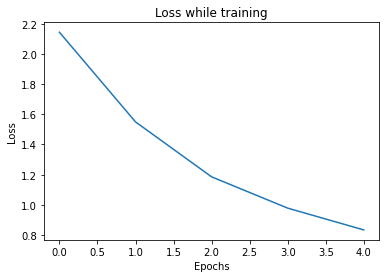

In [68]:
plt.plot(mean_losses)
plt.title("Loss while training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
